In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score as sk_silhouette_score, davies_bouldin_score
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations

In [2]:
file_name = 'Businesses.csv'
df = pd.read_csv(file_name)

print(f'original data size: {df.shape[0]} rows')

# df.head()

original data size: 52268 rows


In [3]:
# ---------------------
# 1. Data Preprocessing
# ---------------------

#handling missing values:
numerical_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
bool_cols = ["delivery", "parking"]
categorical_cols = df.select_dtypes(include="object").columns.tolist()

df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())
df[bool_cols] = df[bool_cols].fillna(df[bool_cols].mode())
df[categorical_cols] = df[categorical_cols].fillna('Unknown')

#boolean to int
df[bool_cols] = df[bool_cols].astype(int)

# extract top 10 categories from the entire dataset
categories = df["categories"].str.split(", ")
top_categories = categories.explode().value_counts().head(10).index.tolist()

for cat in top_categories:
    df[f'cat_{cat}'] = categories.apply(lambda cats: int(cat in cats if isinstance(cats, list) else False))
df = df.drop(columns=["categories"])

excluded_cols = ['business_id', 'name', 'address', 'city', 'state', 'postal_code','Monday_opening',
                      'Monday_closing', 'Tuesday_opening', 'Tuesday_closing', 'Wednesday_opening', 'Wednesday_closing',
                      'Thursday_opening', 'Thursday_closing','Friday_opening', 'Friday_closing',
                      'Saturday_opening', 'Saturday_closing', 'Sunday_opening', 'Sunday_closing']

cat_cols = df.select_dtypes(include="object").columns.tolist()
cat_cols = [col for col in cat_cols if col not in excluded_cols]
df[cat_cols] = df[cat_cols].astype(str)

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_cats = encoder.fit_transform(df[cat_cols])
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(cat_cols), index=df.index)

# Drop original categorical columns and concatenate encoded versions
df = df.drop(columns=cat_cols)
data = pd.concat([df, encoded_cat_df], axis=1)

data.head()
data.columns


Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'price_range', 'parking', 'delivery', 'Monday_opening',
       'Monday_closing', 'Monday_hours_open', 'Tuesday_opening',
       'Tuesday_closing', 'Tuesday_hours_open', 'Wednesday_opening',
       'Wednesday_closing', 'Wednesday_hours_open', 'Thursday_opening',
       'Thursday_closing', 'Thursday_hours_open', 'Friday_opening',
       'Friday_closing', 'Friday_hours_open', 'Saturday_opening',
       'Saturday_closing', 'Saturday_hours_open', 'Sunday_opening',
       'Sunday_closing', 'Sunday_hours_open', 'cat_Restaurants', 'cat_Food',
       'cat_Nightlife', 'cat_Sandwiches', 'cat_Bars',
       'cat_American (Traditional)', 'cat_Pizza', 'cat_Fast Food',
       'cat_Breakfast & Brunch', 'cat_American (New)',
       'accepts_credit_cards_False', 'accepts_credit_cards_True',
       'accepts_credit_cards_Unknown', 'takeout_False', 'takeout_True

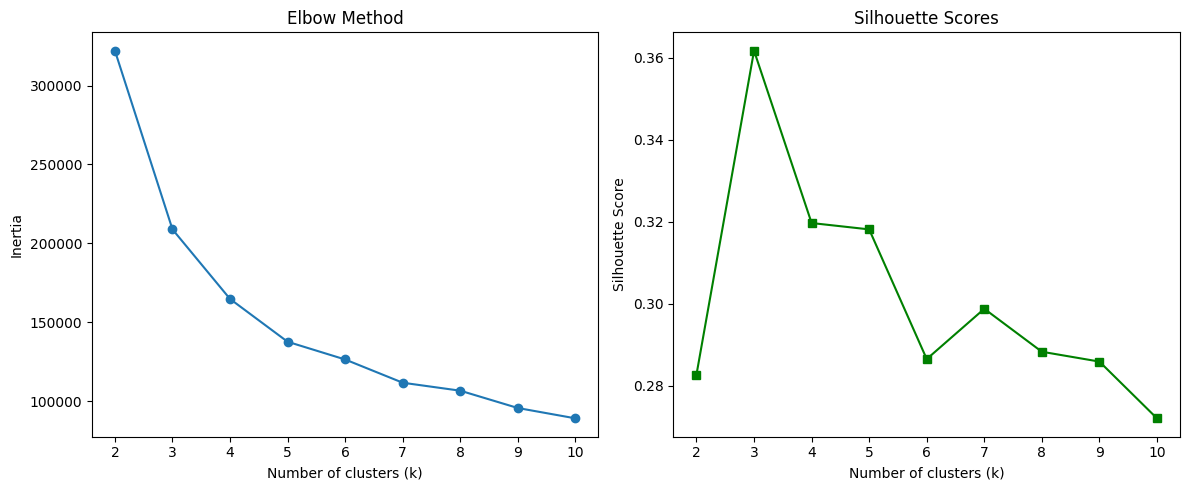

In [11]:
#-------------------------
# 2. Clustering using PCA
#-------------------------

pca_data = data[['latitude', 'longitude', 'review_count', 'is_open', 'price_range',
       'parking', 'delivery', 'cat_Restaurants', 'cat_Food', 'cat_Nightlife',
       'cat_Sandwiches', 'cat_Bars', 'cat_American (Traditional)', 'cat_Pizza',
       'cat_Fast Food', 'cat_Breakfast & Brunch', 'cat_American (New)',
       'accepts_credit_cards_False', 'accepts_credit_cards_True',
       'takeout_False', 'takeout_True', 'wifi_False', 'wifi_True',
       'outdoor_seating_False', 'outdoor_seating_True', 'reservations_False',
       'reservations_True', 'reservations_Unknown', 'good_for_groups_False',
       'good_for_groups_True']]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(pca_data)

pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_data)

inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_result)
    inertia.append(kmeans.inertia_)
    score = sk_silhouette_score(pca_result, kmeans.labels_)
    silhouette_scores.append(score)

# === Elbow Plot ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')

# === Silhouette Score Plot ===
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='s', color='green')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()



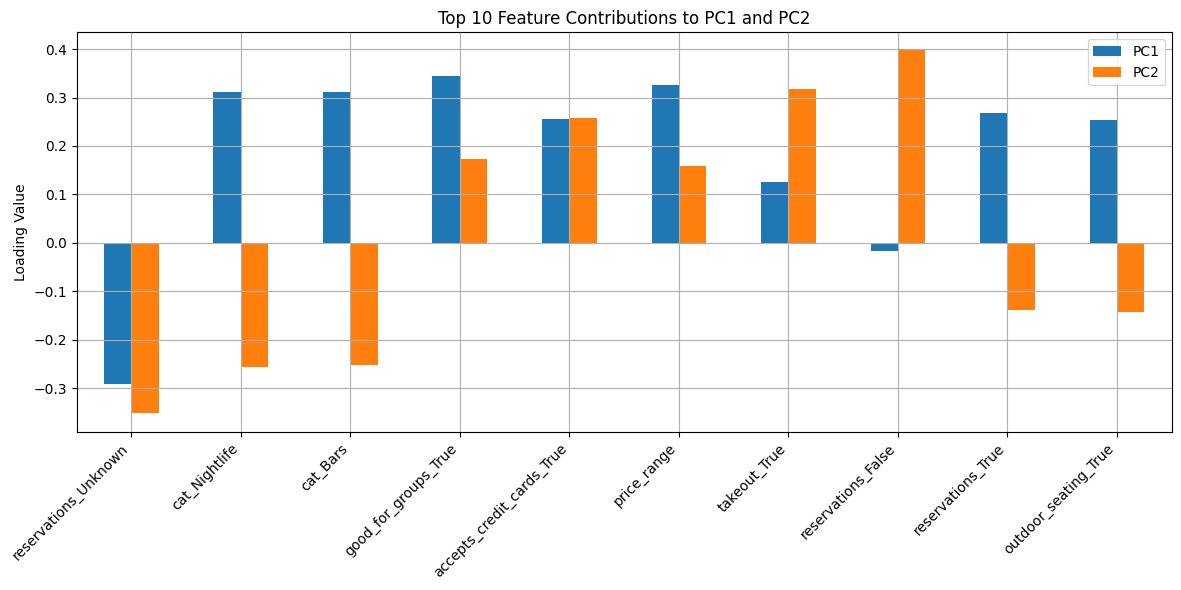

In [18]:
#-------------------------------------------------------
# 3. Influence of Original Features on the first 2 PCAs:
#-------------------------------------------------------

# Loadings: influence of each original feature on each PC
features = pca_data.columns
loadings = pca.components_[:2]  # First two PCs


pc_df = pd.DataFrame(loadings.T, columns=['PC1', 'PC2'], index=features)

pc_df['abs_sum'] = pc_df[['PC1', 'PC2']].abs().sum(axis=1)
top_features = pc_df.sort_values(by='abs_sum', ascending=False).head(10)

# Plot
top_features[['PC1', 'PC2']].plot(kind='bar', figsize=(12, 6))
plt.title('Top 10 Feature Contributions to PC1 and PC2')
plt.ylabel('Loading Value')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()


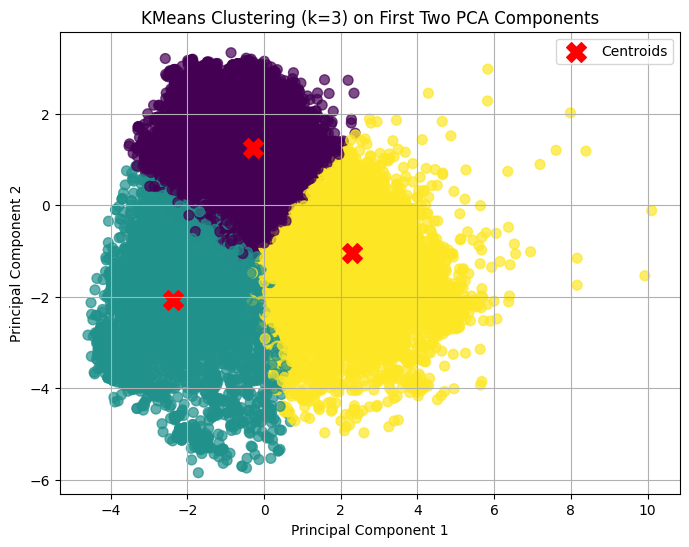

In [12]:
# --------------------------------------------------------
# 4. Visualizing Clustering with K=3 and first 2 PCs
# --------------------------------------------------------

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_result)

# Plot clusters using first two PCA components
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            c='red', marker='X', s=200, label='Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering (k=3) on First Two PCA Components')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# --------------------------------------------------------
# 5. Finding most relevant features given a subset of data
# --------------------------------------------------------

#top cities based on review count:

highest_review_city = data.groupby('city')['review_count'].count().sort_values(ascending=False).head(10)
print(highest_review_city)


#sampled dataset: businesses in Philadelphia only

sample_data = data[(data['city'] == 'Philadelphia') & (data['review_count'] > 500)]
print(f'sampled data size: {sample_data.shape[0]} rows')

S = sample_data[['latitude', 'longitude', 'review_count', 'is_open', 'price_range',
       'parking', 'delivery', 'cat_Restaurants', 'cat_Food', 'cat_Nightlife',
       'cat_Sandwiches', 'cat_Bars', 'cat_American (Traditional)', 'cat_Pizza',
       'cat_Fast Food', 'cat_Breakfast & Brunch', 'cat_American (New)',
       'accepts_credit_cards_False', 'accepts_credit_cards_True',
       'takeout_False', 'takeout_True', 'wifi_False', 'wifi_True',
       'outdoor_seating_False', 'outdoor_seating_True', 'reservations_False',
       'reservations_True', 'reservations_Unknown', 'good_for_groups_False',
       'good_for_groups_True']]
feature_combos = list(combinations(S.columns, 3))

best_score = -1
best_features = None

for combo in feature_combos:
    subset = S[list(combo)]
    try:

        scaled_subset = StandardScaler().fit_transform(subset)


        kmeans = KMeans(n_clusters=3, random_state=0)
        labels = kmeans.fit_predict(scaled_subset)


        score = sk_silhouette_score(scaled_subset, labels)

        if score > best_score:
            best_score = score
            best_features = combo
    except Exception as e:
        print(f"Skipping {combo} due to error: {e}")
        continue

print(f"Best 3-feature combination: {best_features} with silhouette score: {best_score:.4f}")

city
Philadelphia    5852
Tampa           2960
Indianapolis    2862
Nashville       2502
Tucson          2466
New Orleans     2259
Edmonton        2166
Saint Louis     1790
Reno            1286
Boise            847
Name: review_count, dtype: int64
sampled data size: 260 rows


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Best 3-feature combination: ('is_open', 'cat_Restaurants', 'cat_Fast Food') with silhouette score: 1.0000


k = 2 -> Silhouette Score = 0.7256, Davies-Bouldin Score = 0.4923
k = 3 -> Silhouette Score = 0.9782, Davies-Bouldin Score = 0.1674
k = 4 -> Silhouette Score = 1.0000, Davies-Bouldin Score = 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


k = 5 -> Silhouette Score = 1.0000, Davies-Bouldin Score = 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


k = 6 -> Silhouette Score = 1.0000, Davies-Bouldin Score = 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


k = 7 -> Silhouette Score = 1.0000, Davies-Bouldin Score = 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


k = 8 -> Silhouette Score = 1.0000, Davies-Bouldin Score = 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


k = 9 -> Silhouette Score = 1.0000, Davies-Bouldin Score = 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


k = 10 -> Silhouette Score = 1.0000, Davies-Bouldin Score = 0.0000


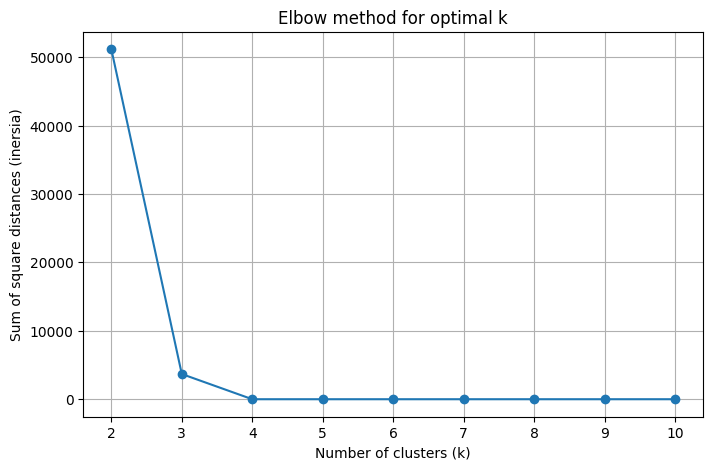

In [19]:
# ----------------------------------------------------------------------------------
# 6. Performing clustering on the whole dataset given the optimal subset of features
# ----------------------------------------------------------------------------------

X = data[['is_open', 'cat_Restaurants', 'cat_Fast Food']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# evaluations:
inertia = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    sil_score = sk_silhouette_score(X_scaled, labels)
    db_score = davies_bouldin_score(X_scaled, labels)

    print(f"k = {k} -> Silhouette Score = {sil_score:.4f}, Davies-Bouldin Score = {db_score:.4f}")

# Plotting the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of square distances (inersia)')
plt.title('Elbow method for optimal k')
plt.xticks(K_range)
plt.grid(True)
plt.show()


While the above results look nearly perfect, all three features are binary. As a result, they create only a few distinct, repeated combinations in the dataset. When the data is scaled and passed through KMeans, the algorithm ends up grouping identical points together. Since those identical points are clearly “far” from other types, the silhouette score becomes artificially high, even perfect, because:

Intra-cluster distance = 0 (all points are exactly the same)

Inter-cluster distance = large enough to separate the groups

So the algorithm appears to be doing a flawless job, but in reality, it's just dividing up a very limited set of repetitive patterns, not truly discovering meaningful clusters.
This also explains why the algorithm can’t go beyond k = 4: there simply aren’t enough distinct data points to form more clusters.

k = 2 -> Silhouette Score = 0.0870, Davies-Bouldin Score = 3.4937
k = 3 -> Silhouette Score = 0.0755, Davies-Bouldin Score = 2.9843
k = 4 -> Silhouette Score = 0.1058, Davies-Bouldin Score = 2.4648
k = 5 -> Silhouette Score = 0.1082, Davies-Bouldin Score = 2.6060
k = 6 -> Silhouette Score = 0.1096, Davies-Bouldin Score = 2.5092
k = 7 -> Silhouette Score = 0.1125, Davies-Bouldin Score = 2.3862
k = 8 -> Silhouette Score = 0.1021, Davies-Bouldin Score = 2.5610
k = 9 -> Silhouette Score = 0.1049, Davies-Bouldin Score = 2.4286
k = 10 -> Silhouette Score = 0.1023, Davies-Bouldin Score = 2.4645


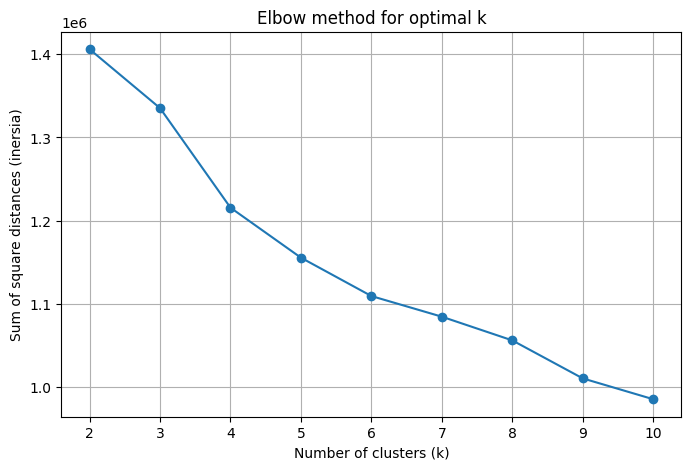

In [ ]:
# --------------------------------------------------------------------------------------
# 7. Running clustering algorithm for different subset of features and comparing results
# --------------------------------------------------------------------------------------

## Test 1:

X2 = data[['latitude', 'longitude', 'review_count', 'is_open', 'price_range',
       'parking', 'delivery', 'cat_Restaurants', 'cat_Food', 'cat_Nightlife',
       'cat_Sandwiches', 'cat_Bars', 'cat_American (Traditional)', 'cat_Pizza',
       'cat_Fast Food', 'cat_Breakfast & Brunch', 'cat_American (New)',
       'accepts_credit_cards_False', 'accepts_credit_cards_True',
       'takeout_False', 'takeout_True', 'wifi_False', 'wifi_True',
       'outdoor_seating_False', 'outdoor_seating_True', 'reservations_False',
       'reservations_True', 'reservations_Unknown', 'good_for_groups_False',
       'good_for_groups_True']]

scaler = StandardScaler()
X_scaled2 = scaler.fit_transform(X2)

# evaluations:
inertia = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled2)
    inertia.append(kmeans.inertia_)
    sil_score = sk_silhouette_score(X_scaled2, labels)
    db_score = davies_bouldin_score(X_scaled2, labels)

    print(f"k = {k} -> Silhouette Score = {sil_score:.4f}, Davies-Bouldin Score = {db_score:.4f}")

# Plotting the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of square distances (inersia)')
plt.title('Elbow method for optimal k')
plt.xticks(K_range)
plt.grid(True)
plt.show()


k = 2 -> Silhouette Score = 0.2848, Davies-Bouldin Score = 2.0505
k = 3 -> Silhouette Score = 0.3039, Davies-Bouldin Score = 1.2433
k = 4 -> Silhouette Score = 0.3259, Davies-Bouldin Score = 1.2480
k = 5 -> Silhouette Score = 0.3664, Davies-Bouldin Score = 1.0964
k = 6 -> Silhouette Score = 0.3750, Davies-Bouldin Score = 1.1425
k = 7 -> Silhouette Score = 0.3855, Davies-Bouldin Score = 1.1359
k = 8 -> Silhouette Score = 0.3859, Davies-Bouldin Score = 0.9602
k = 9 -> Silhouette Score = 0.3935, Davies-Bouldin Score = 0.9386
k = 10 -> Silhouette Score = 0.4088, Davies-Bouldin Score = 0.9183


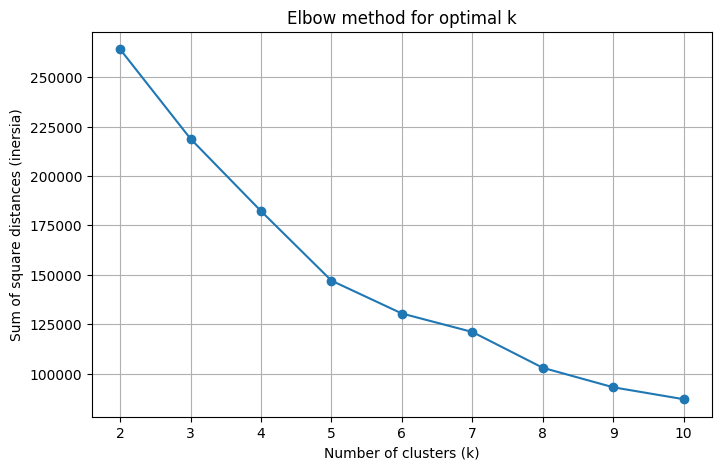

In [ ]:
## Test 2:

X2 = data[['latitude', 'longitude', 'review_count', 'is_open', 'price_range',
           'cat_Restaurants', 'cat_Fast Food']]

scaler = StandardScaler()
X_scaled2 = scaler.fit_transform(X2)

# evaluations:
inertia = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled2)
    inertia.append(kmeans.inertia_)
    sil_score = sk_silhouette_score(X_scaled2, labels)
    db_score = davies_bouldin_score(X_scaled2, labels)

    print(f"k = {k} -> Silhouette Score = {sil_score:.4f}, Davies-Bouldin Score = {db_score:.4f}")

# Plotting the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of square distances (inersia)')
plt.title('Elbow method for optimal k')
plt.xticks(K_range)
plt.grid(True)
plt.show()


k = 2 -> Silhouette Score = 0.4755, Davies-Bouldin Score = 0.7420
k = 3 -> Silhouette Score = 0.5126, Davies-Bouldin Score = 0.8194
k = 4 -> Silhouette Score = 0.5397, Davies-Bouldin Score = 0.7461
k = 5 -> Silhouette Score = 0.5253, Davies-Bouldin Score = 0.6385
k = 6 -> Silhouette Score = 0.6554, Davies-Bouldin Score = 0.5303
k = 7 -> Silhouette Score = 0.6667, Davies-Bouldin Score = 0.5127
k = 8 -> Silhouette Score = 0.6197, Davies-Bouldin Score = 0.6141
k = 9 -> Silhouette Score = 0.6298, Davies-Bouldin Score = 0.5841
k = 10 -> Silhouette Score = 0.6551, Davies-Bouldin Score = 0.5444


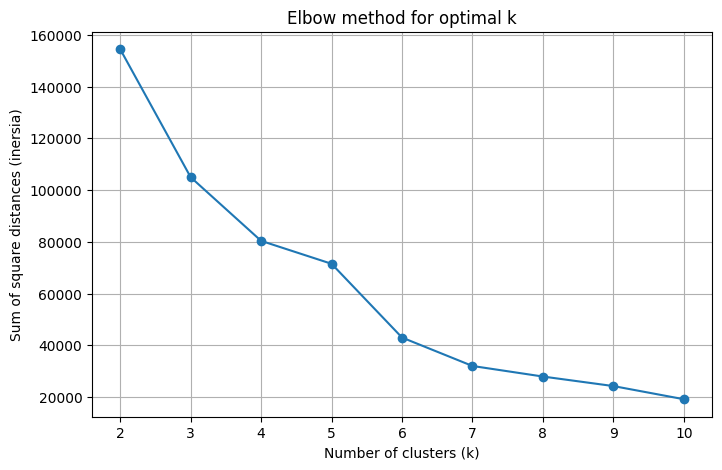

In [35]:
## Test 3:

X3 = data[['is_open', 'review_count', 'price_range', 'cat_Restaurants', 'cat_Fast Food']]
scaler = StandardScaler()
X_scaled3 = scaler.fit_transform(X3)


inertia = []
silhouette_scores = []
db_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels3 = kmeans.fit_predict(X_scaled3)

    inertia.append(kmeans.inertia_)
    sil_score = sk_silhouette_score(X_scaled3, labels3)
    db_score = davies_bouldin_score(X_scaled3, labels3)

    silhouette_scores.append(sil_score)
    db_scores.append(db_score)

    print(f"k = {k} -> Silhouette Score = {sil_score:.4f}, Davies-Bouldin Score = {db_score:.4f}")

# Plotting the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of square distances (inersia)')
plt.title('Elbow method for optimal k')
plt.xticks(K_range)
plt.grid(True)
plt.show()

looks like the best subset of features are 'is_open', 'review_count', and 'price_range' and the best number of clusters for this subset is K=4.

k = 4 -> Silhouette Score = 0.5397, Davies-Bouldin Score = 0.7461

Since price range is consists of only 5 unique values, we jitter the values for better visual representation.

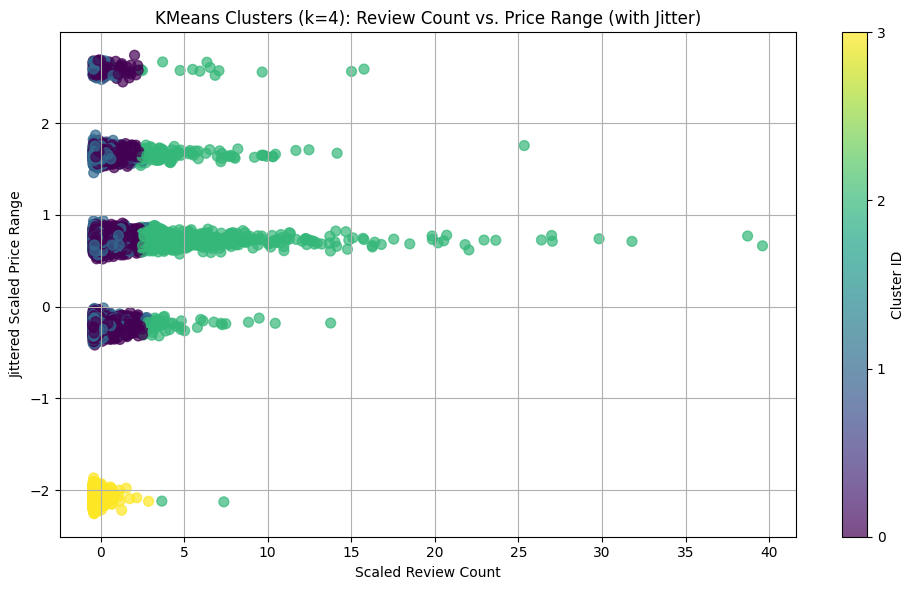

In [60]:
# ------------------------------------------------
# 8. 2D Cluster Plot: review_count vs price_range
# ------------------------------------------------
k = 4
kmeans_2d = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans_2d.fit_predict(X_scaled3)

jittered_price = X_scaled3[:, 2] + np.random.normal(0, 0.05, size=X_scaled3.shape[0])

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_scaled3[:, 1],
    jittered_price,
    c=cluster_labels,
    cmap='viridis',
    s=50,
    alpha=0.7
)

plt.xlabel('Scaled Review Count')
plt.ylabel('Jittered Scaled Price Range')
plt.title('KMeans Clusters (k=4): Review Count vs. Price Range (with Jitter)')

cbar = plt.colorbar(scatter)
cbar.set_ticks(range(k))
cbar.set_label('Cluster ID')

plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
# -----------------------
# 9. Analyzing Clusters
# -----------------------

data['cluster_id'] = cluster_labels

cluster_summary = data.groupby('cluster_id').agg({
    'stars': ['mean', 'median'],
    'review_count': ['mean', 'median'],
    'price_range': ['mean', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan]
})

# Rename columns for clarity
cluster_summary.columns = ['stars_mean', 'stars_median',
                           'review_count_mean', 'review_count_median',
                           'price_range_mean', 'price_range_mode']

# Optional: reset index if you want a flat DataFrame
cluster_summary = cluster_summary.reset_index()

# Show the summary
cluster_summary



,cluster_id,stars_mean,stars_median,review_count_mean,review_count_median,price_range_mean,price_range_mode
0,0,2.630088,2.5,32.089769,18.0,0.900015,1.0
1,1,3.685236,4.0,81.709274,45.0,1.112804,2.0
2,2,3.530333,3.5,49.936067,24.0,1.456289,2.0
3,3,3.995081,4.0,873.312720,657.0,2.071680,2.0
